In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
%matplotlib inline

[[-0.50588235 -0.54509804 -0.44313725 ... -0.28627451 -0.28627451
  -0.25490196]
 [-0.01176471 -0.12941176 -0.09803922 ... -0.79607843 -0.75686275
  -0.76470588]
 [-0.56862745 -0.71764706 -0.85882353 ... -0.19215686 -0.19215686
  -0.15294118]
 ...
 [-0.7254902  -0.81960784 -0.78039216 ... -0.38039216 -0.37254902
  -0.36470588]
 [-0.7254902  -0.79607843 -0.75686275 ... -0.35686275 -0.36470588
  -0.38039216]
 [-0.70196078 -0.67058824 -0.67843137 ... -0.34117647 -0.34901961
  -0.38039216]]


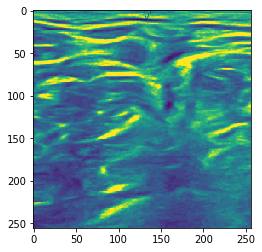

In [2]:
files = os.listdir("ultrasound-nerve-segmentation/train")
im = Image.open("ultrasound-nerve-segmentation/train/"+files[0]).resize((256, 256))
arr = np.asarray(im)
plt.imshow(np.asarray(im))
print((2*(arr - np.min(arr))/np.ptp(arr)-1))

In [3]:
image_names = []
for f in files:
    if '_mask' not in f:
        image_names.append(os.path.splitext(f)[0])
        
train_names, test_names = train_test_split(image_names, test_size=0.1)

In [4]:
def get_batches(batch_size):
    for i in range(0, len(train_names[:16]), batch_size):
        images = []
        labels = []
        for train_name in train_names[i:i+batch_size]:
            im = Image.open("ultrasound-nerve-segmentation/train/"+train_name+".tif")
            lb = Image.open("ultrasound-nerve-segmentation/train/"+train_name+"_mask.tif")
            # resize and normalize
            im_arr = np.asarray(im.resize((256, 256)))
            im_arr = 2*(im_arr - np.min(im_arr))/np.ptp(im_arr)-1
            lb_arr = np.array(lb.resize((256, 256)))
            lb_arr[lb_arr > 0] = 1
            # stack 3 channels so vgg works
            im_arr = np.stack([im_arr, im_arr, im_arr], axis=2)
#             lb_arr = np.stack([lb, lb, lb], axis=2)
            images.append(im_arr)
            labels.append(lb_arr)
        yield np.array(images), np.array(labels)

In [5]:
sess = tf.Session()
num_classes = 1
correct_label = tf.placeholder(tf.float32, [None, None, None])
learning_rate = tf.placeholder(tf.float32)
# load VGG16 weights
model = tf.saved_model.loader.load(sess, ['vgg16'], "vgg")

graph = tf.get_default_graph()
image_input = graph.get_tensor_by_name("image_input:0")
keep_prob = graph.get_tensor_by_name('keep_prob:0')
layer3 = graph.get_tensor_by_name('layer3_out:0')
layer4 = graph.get_tensor_by_name('layer4_out:0')
layer7 = graph.get_tensor_by_name('layer7_out:0')
    
#     return image_input, keep_prob, layer3, layer4, layer7

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from vgg/variables/variables


In [6]:
# FCN 32
# fcn8 = tf.layers.conv2d(layer7, filters=num_classes, kernel_size=1, name='fcn8')
# fcn9 = tf.layers.conv2d_transpose(fcn8, filters=num_classes, kernel_size=, strides=32, name='fcn32_out')
# # FCN8 layers

# # fcn9 = tf.layers.conv2d_transpose(fcn8, filters=, kernel_size=2, name='fcn9')
# print(tf.shape(fcn9))

# Apply 1x1 convolution in place of fully connected layer
fcn8 = tf.layers.conv2d(layer7, filters=num_classes, kernel_size=1, name="fcn8")

# Upsample fcn8 with size depth=(4096?) to match size of layer 4 so that we can add skip connection with 4th layer
fcn9 = tf.layers.conv2d_transpose(fcn8, filters=layer4.get_shape().as_list()[-1],
kernel_size=4, strides=(2, 2), padding='SAME', name="fcn9")

# Add a skip connection between current final layer fcn8 and 4th layer
fcn9_skip_connected = tf.add(fcn9, layer4, name="fcn9_plus_vgg_layer4")

# Upsample again
fcn10 = tf.layers.conv2d_transpose(fcn9_skip_connected, filters=layer3.get_shape().as_list()[-1],
kernel_size=4, strides=(2, 2), padding='SAME', name="fcn10_conv2d")

# Add skip connection
fcn10_skip_connected = tf.add(fcn10, layer3, name="fcn10_plus_vgg_layer3")

# Upsample again
fcn11 = tf.layers.conv2d_transpose(fcn10_skip_connected, filters=num_classes,
kernel_size=16, strides=(8, 8), padding='SAME', name="fcn11")

output_layer = fcn11
#     return fcn11

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.conv2d_transpose instead.


In [11]:
learning_rate = 1e-3
logits = tf.reshape(output_layer, (-1, num_classes), name="fcn_logits")
correct_label_reshaped = tf.reshape(correct_label, (-1, num_classes))
cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=correct_label_reshaped)
loss_op = tf.reduce_mean(cross_entropy)
train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss_op)
#     return loss_op, train_op
predicted = tf.reshape(tf.nn.sigmoid(output_layer), (-1, num_classes), name='predicted')
correct_pred = tf.equal(tf.round(predicted), correct_label_reshaped)
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

In [12]:
# training
num_epochs = 7
batch_size = 8
keep_prob_val = 0.5

# labels = np.zeros((8,32,32))
# images = np.zeros((8,32,32,3))
sess = tf.Session()
epoch_accuracy = []
# with tf.Session() as sess:
# The calls to tf.zeros above do not actually instantiate the values
# for w1 and w2; the following line tells TensorFlow to instantiate
# the values of all Tensors (like w1 and w2) that live in the graph.
print("initializing variables...")
sess.run(tf.global_variables_initializer())
sess.run(tf.local_variables_initializer())
for i in range(num_epochs):
    print("Starting Epoch {} ...".format(i + 1))
    total_loss = 0
    for img_batch, lbl_batch in get_batches(batch_size):
        loss, _ = sess.run([loss_op, train_op],
                          feed_dict={image_input:img_batch, correct_label:lbl_batch, keep_prob:keep_prob_val})
        
        acc = sess.run(accuracy, feed_dict={image_input: img_batch, correct_label: lbl_batch, 
                                                               keep_prob:1.0})
        
        epoch_accuracy.append(acc)
        total_loss += loss
    print("Loss = {:.3f}".format(total_loss))
    print("Accuracy = {:.3f}".format(np.mean(epoch_accuracy)))
    print()

#         # Here we actually run the graph, using the feed_dict to pass the
#         # value to bind to the placeholder for x; we ask TensorFlow to compute
#         # the value of the scores Tensor, which it returns as a numpy array.
#         print("running graph...")
#         loss, _ = sess.run([loss_op, train_op], feed_dict={image_input:images, correct_label:labels, keep_prob:keep_prob_val})
#         print(loss.shape)

initializing variables...
Starting Epoch 1 ...
Loss = 25.954
Accuracy= 0.859

Starting Epoch 2 ...
Loss = 26.161
Accuracy= 0.886

Starting Epoch 3 ...
Loss = 13.144
Accuracy= 0.883

Starting Epoch 4 ...
Loss = 3.359
Accuracy= 0.906

Starting Epoch 5 ...
Loss = 1.810
Accuracy= 0.917

Starting Epoch 6 ...
Loss = 0.752
Accuracy= 0.928

Starting Epoch 7 ...
Loss = 0.361
Accuracy= 0.935



In [9]:
saver = tf.train.Saver()
# Save the variables to disk.
save_path = saver.save(sess, "/tmp/model.ckpt")
print("Model saved in path: %s" % save_path)

Model saved in path: /tmp/model.ckpt


In [16]:
#load model
# Add ops to save and restore all the variables.
saver = tf.train.Saver()

# Later, launch the model, use the saver to restore variables from disk, and
# do some work with the model.
# sess = tf.Session()
# Restore variables from disk.
saver.restore(sess, "/tmp/model.ckpt")
print("Model restored.")

INFO:tensorflow:Restoring parameters from /tmp/model.ckpt
Model restored.
<class 'tuple'>


In [20]:
im = Image.open("ultrasound-nerve-segmentation/train/"+train_names[0]+".tif")
im_arr = np.array(im.resize((256, 256)))
im_arr = 2*(im_arr - np.min(im_arr))/np.ptp(im_arr)-1
im_arr = np.stack([im_arr, im_arr, im_arr], axis=2)
im_arr = np.reshape(im_arr, (1, im_arr.shape[0], im_arr.shape[1], im_arr.shape[2]))
probs = tf.nn.sigmoid(output_layer)
prediction = sess.run(probs, feed_dict={image_input:im_arr, keep_prob:1})
prediction.shape

(1, 256, 256, 1)

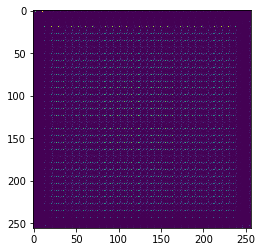

In [25]:
# prediction[prediction > 0.5] = 1
# prediction[prediction <= 0.5] = 0
# print(prediction)
lb = Image.open("ultrasound-nerve-segmentation/train/"+train_names[0]+"_mask.tif")
lb_arr = np.array(lb.resize((256, 256)))
# print(lb_arr.shape)
# plt.imshow(lb_arr)
plt.imshow(np.reshape(prediction, (prediction.shape[1], prediction.shape[2])))